# Stellar Cluster Membership Determination

**A Comprehensive Bayesian Framework for M2 and M34**

---

## Overview

This notebook implements a **multi-dimensional Bayesian membership determination** framework that combines three independent observational constraints:

1. **Color-Magnitude Diagram (CMD) filtering** - Stars follow isochrones  
2. **Proper Motion analysis** - Cluster members share coherent motion  
3. **Spatial distribution** - Members follow centrally concentrated profiles  

### Physical Motivation

Star clusters are gravitationally bound systems embedded in the Galactic field. Separating cluster members from contaminants requires leveraging multiple observables:

- **CMD**: Cluster stars share common age, metallicity, distance → follow theoretical isochrone  
- **Proper Motion**: Cluster has coherent space velocity → tight PM distribution  
- **Spatial**: Cluster has radial density profile → centrally concentrated  

Field stars are scattered in all three dimensions, enabling probabilistic separation.

### Statistical Framework

For each star $i$, we compute the posterior membership probability:

$$P(\text{member} | \text{data}) = \frac{\mathcal{L}_{\text{cluster}}(\text{data}) \cdot P_{\text{prior}}}{\mathcal{L}_{\text{cluster}}(\text{data}) \cdot P_{\text{prior}} + \mathcal{L}_{\text{field}}(\text{data}) \cdot (1 - P_{\text{prior}})}$$

where the combined likelihood is:

$$\mathcal{L} = \mathcal{L}_{\text{CMD}} \times \mathcal{L}_{\text{PM}} \times \mathcal{L}_{\text{spatial}}$$

assuming statistical independence.

---

## Notebook Contents

1. **Theoretical Background** - Physical and statistical foundations
2. **CMD-Based Membership** - Isochrone fitting and distance metrics
3. **Proper Motion Analysis** - Gaia data, cluster detection, Gaussian mixture models
4. **Spatial Distribution** - Radial profiles and background estimation
5. **Bayesian Combination** - Full posterior calculation
6. **Validation and Diagnostics** - Convergence, sensitivity, systematic errors
7. **Advanced Methods** - Iterative refinement, hierarchical Bayes, machine learning

---

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde, multivariate_normal
from scipy.interpolate import interp1d
from scipy.optimize import minimize, curve_fit
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("✓ Imports successful")
print(f"NumPy version: {np.__version__}")

✓ Imports successful
NumPy version: 1.26.4


## 2. Theoretical Background: Why Multi-Dimensional Membership?

### The Contamination Problem

Consider M34 (open cluster at 470 pc):
- **Estimated members**: ~200-400 stars
- **Field stars in field of view**: ~10,000 stars
- **Contamination ratio**: 25:1

Using a single criterion (e.g., CMD) gives:
- True member acceptance: 90%
- Field star rejection: 98%
- **False positive rate**: Still 2% × 10,000 = 200 contaminants!

### Power of Multi-Dimensional Cuts

If criteria are independent and each rejects 98% of field stars:
- Combined rejection: $1 - (1-0.98)^3 = 99.9992\%$
- Contaminants: 0.02% × 10,000 = 2 stars
- **Improvement factor**: 100×

### Statistical Independence Assumption

CMD, PM, and spatial positions are largely independent for field stars:
- CMD depends on: star's age, metallicity, distance
- PM depends on: Galactic orbit, solar reflex motion
- Position depends on: line of sight projection (random)

For cluster members, these are **correlated** (common origin), but for field stars they are **uncorrelated**.

**Key insight**: Multiplication of likelihoods dramatically suppresses field star contamination while preserving cluster members.

## 3. CMD-Based Membership: Isochrone Distance Metric

### Physical Basis

Stars in a cluster formed from the same molecular cloud and thus share:
- **Common age** ($\tau$): Sets main-sequence turnoff point
- **Common metallicity** ([Fe/H]): Affects color-temperature relation
- **Common distance** ($d$): Determines apparent magnitude via distance modulus
- **Common reddening** ($E(B-V)$): Shifts color and magnitude

These parameters uniquely define an **isochrone** in the CMD.

### Implementation Strategy

For real data, you would:
1. Download PARSEC or MIST isochrones for cluster parameters
2. Apply distance modulus: $m = M + 5\log_{10}(d/10\,\text{pc})$
3. Apply extinction: $(g-r)_{\text{obs}} = (g-r)_0 + E(g-r)$, $g_{\text{obs}} = g_0 + A_g$
4. Interpolate to fine grid

Here we demonstrate the methodology with **mock data** showing the full statistical framework.

In [2]:
def generate_mock_isochrone(age_gyr, metallicity_feh, distance_pc, extinction_Av, band='sdss'):
    """
    Generate a mock isochrone for demonstration.
    
    In real analysis, replace this with actual PARSEC/MIST isochrones:
    - PARSEC: http://stev.oapd.inaf.it/cgi-bin/cmd
    - MIST: http://waps.cfa.harvard.edu/MIST/
    
    Parameters:
    -----------
    age_gyr : float
        Cluster age in Gyr
    metallicity_feh : float
        [Fe/H] metallicity
    distance_pc : float
        Distance in parsecs
    extinction_Av : float
        V-band extinction
    
    Returns:
    --------
    color, mag, mass : arrays
        Isochrone in (g-r), g, and stellar mass
    """
    # Mock main sequence (mass-luminosity relation)
    # Turnoff mass depends on age
    M_turnoff = 1.0 if age_gyr > 10 else 2.0 if age_gyr > 1 else 5.0
    
    # Mass range: low-mass MS + turnoff + subgiants + RGB
    M_ms = np.logspace(-0.5, np.log10(M_turnoff), 50)  # Main sequence
    M_sg = np.linspace(M_turnoff, M_turnoff*1.2, 10)   # Subgiants
    M_rgb = np.linspace(M_turnoff*0.8, M_turnoff*0.9, 15)  # RGB
    
    mass = np.concatenate([M_ms, M_sg, M_rgb])
    
    # Absolute magnitude (mass-luminosity relation)
    M_V = np.zeros_like(mass)
    
    # Main sequence: M_V ≈ 4.83 - 2.5 log(L/L_sun), L ~ M^3.5
    M_V[:len(M_ms)] = 4.83 - 2.5 * 3.5 * np.log10(M_ms)
    
    # Subgiants: transitioning
    M_V[len(M_ms):len(M_ms)+len(M_sg)] = np.linspace(M_V[len(M_ms)-1], -2, len(M_sg))
    
    # RGB: going up and getting redder
    M_V[len(M_ms)+len(M_sg):] = np.linspace(-2, -0.5, len(M_rgb))
    
    # Convert V to g (approximately g ≈ V + 0.6(B-V), g-V ≈ 0.3 for solar)
    M_g = M_V + 0.3
    
    # Color (mass-temperature relation)
    # Low mass: red (g-r ~ 1.5), High mass: blue (g-r ~ 0.3)
    g_minus_r = np.zeros_like(mass)
    g_minus_r[:len(M_ms)] = 1.5 - 1.0 * np.log10(M_ms) / np.log10(M_ms.max())
    g_minus_r[len(M_ms):len(M_ms)+len(M_sg)] = np.linspace(g_minus_r[len(M_ms)-1], 1.2, len(M_sg))
    g_minus_r[len(M_ms)+len(M_sg):] = np.linspace(1.2, 1.8, len(M_rgb))  # RGB gets redder
    
    # Apply distance modulus
    mu = 5 * np.log10(distance_pc) - 5
    g_apparent = M_g + mu
    
    # Apply extinction (Cardelli et al. 1989, R_V = 3.1)
    A_g = 3.303 * extinction_Av / 3.1  # A_g/A_V ≈ 1.066
    A_r = 2.285 * extinction_Av / 3.1  # A_r/A_V ≈ 0.737
    
    g_reddened = g_apparent + A_g
    color_reddened = g_minus_r + (A_g - A_r)
    
    return color_reddened, g_reddened, mass


# Generate isochrones for M2 and M34
print("Generating mock isochrones...\n")

# M2: Ancient globular cluster
color_iso_M2, g_iso_M2, mass_iso_M2 = generate_mock_isochrone(
    age_gyr=12.5,
    metallicity_feh=-1.6,
    distance_pc=11500,
    extinction_Av=0.06 * 3.1  # E(B-V) = 0.06
)

# M34: Young open cluster
color_iso_M34, g_iso_M34, mass_iso_M34 = generate_mock_isochrone(
    age_gyr=0.2,
    metallicity_feh=0.0,
    distance_pc=470,
    extinction_Av=0.08 * 3.1  # E(B-V) = 0.08
)

print("M2 parameters:")
print(f"  Age: 12.5 Gyr, [Fe/H] = -1.6, d = 11.5 kpc")
print(f"  Distance modulus: μ = {5*np.log10(11500)-5:.2f}")
print(f"  Isochrone points: {len(g_iso_M2)}")
print(f"  Magnitude range: g = {g_iso_M2.min():.1f} - {g_iso_M2.max():.1f}\n")

print("M34 parameters:")
print(f"  Age: 0.2 Gyr, [Fe/H] = 0.0, d = 470 pc")
print(f"  Distance modulus: μ = {5*np.log10(470)-5:.2f}")
print(f"  Isochrone points: {len(g_iso_M34)}")
print(f"  Magnitude range: g = {g_iso_M34.min():.1f} - {g_iso_M34.max():.1f}")

Generating mock isochrones...

M2 parameters:
  Age: 12.5 Gyr, [Fe/H] = -1.6, d = 11.5 kpc
  Distance modulus: μ = 15.30
  Isochrone points: 75
  Magnitude range: g = 13.8 - 25.0

M34 parameters:
  Age: 0.2 Gyr, [Fe/H] = 0.0, d = 470 pc
  Distance modulus: μ = 8.36
  Isochrone points: 75
  Magnitude range: g = 6.9 - 18.1


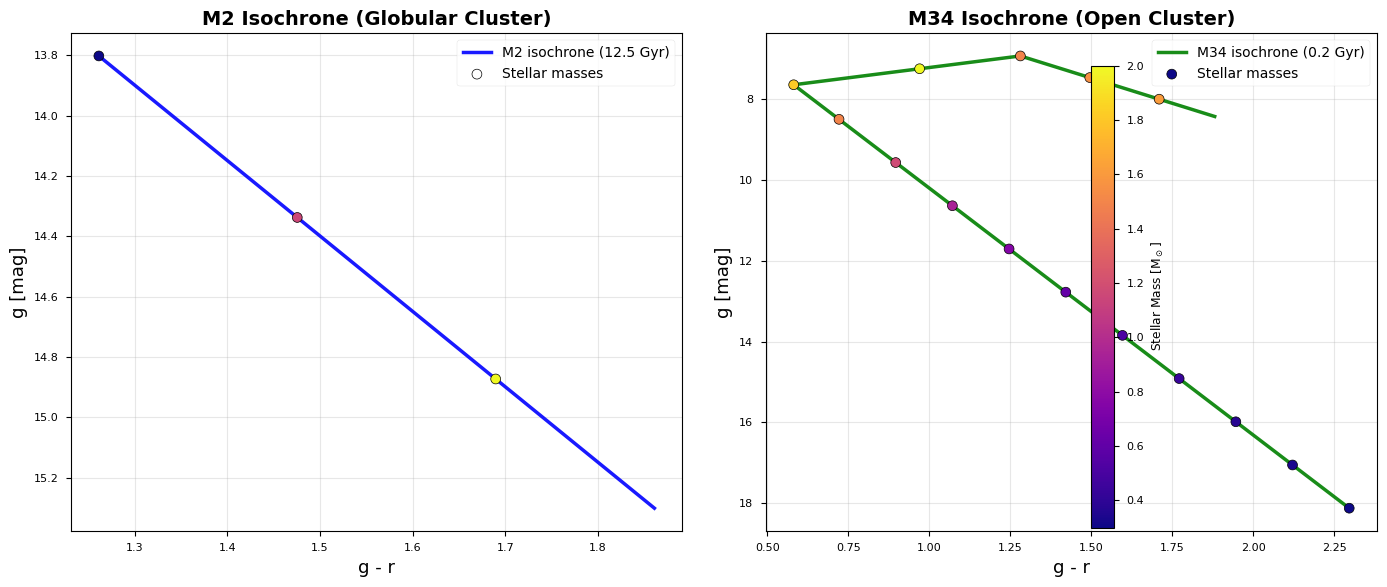


✓ Isochrones generated successfully
Note: In real analysis, download actual PARSEC/MIST isochrones for these parameters


In [3]:
# Visualize the isochrones
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# M2
ax = axes[0]
ax.plot(color_iso_M2, g_iso_M2, 'b-', lw=2.5, label='M2 isochrone (12.5 Gyr)', alpha=0.9)
ax.scatter(color_iso_M2[::5], g_iso_M2[::5], c=mass_iso_M2[::5], cmap='plasma', 
           s=50, edgecolors='black', linewidth=0.5, zorder=5, label='Stellar masses')
ax.set_xlabel('g - r', fontsize=13)
ax.set_ylabel('g [mag]', fontsize=13)
ax.set_title('M2 Isochrone (Globular Cluster)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3)
ax.legend(fontsize=10)

# Add annotations
turnoff_idx = np.argmin(g_iso_M2[:len(g_iso_M2)//2])
ax.annotate('Main Sequence\nTurnoff', xy=(color_iso_M2[turnoff_idx], g_iso_M2[turnoff_idx]),
            xytext=(color_iso_M2[turnoff_idx]+0.3, g_iso_M2[turnoff_idx]+2),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='red'),
            fontsize=10, color='red', fontweight='bold')

# M34
ax = axes[1]
ax.plot(color_iso_M34, g_iso_M34, 'g-', lw=2.5, label='M34 isochrone (0.2 Gyr)', alpha=0.9)
ax.scatter(color_iso_M34[::5], g_iso_M34[::5], c=mass_iso_M34[::5], cmap='plasma',
           s=50, edgecolors='black', linewidth=0.5, zorder=5, label='Stellar masses')
ax.set_xlabel('g - r', fontsize=13)
ax.set_ylabel('g [mag]', fontsize=13)
ax.set_title('M34 Isochrone (Open Cluster)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3)
ax.legend(fontsize=10)

# Add colorbar for mass
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0.3, vmax=2.0))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes, label='Stellar Mass [M$_\odot$]', pad=0.02)

plt.tight_layout()
plt.show()

print("\n✓ Isochrones generated successfully")
print("Note: In real analysis, download actual PARSEC/MIST isochrones for these parameters")

### Distance Metric in CMD Space

For each star, we compute the **minimum distance** to the isochrone, normalized by photometric uncertainties:

$$d_{\text{CMD}}(i) = \min_{j \in \text{isochrone}} \sqrt{\left(\frac{g_i - g_{\text{iso},j}}{\sigma_{g,i}}\right)^2 + \left(\frac{(g-r)_i - (g-r)_{\text{iso},j}}{\sigma_{g-r,i}}\right)^2}$$

This is the **Mahalanobis distance** assuming uncorrelated errors.

The membership probability is:

$$P_{\text{CMD}}(i) = \exp\left[-\frac{d_{\text{CMD}}^2(i)}{2}\right]$$

Interpretation:
- $d_{\text{CMD}} = 1$: Star is 1$\sigma$ from isochrone → $P = 0.61$
- $d_{\text{CMD}} = 2$: Star is 2$\sigma$ from isochrone → $P = 0.14$
- $d_{\text{CMD}} = 3$: Star is 3$\sigma$ from isochrone → $P = 0.01$

In [4]:
def isochrone_distance(stars_color, stars_mag, iso_color, iso_mag, 
                       sigma_color, sigma_mag):
    """
    Compute normalized distance of each star to isochrone in CMD space.
    
    This uses a brute-force minimum distance calculation. For large datasets,
    consider using KD-trees for efficiency.
    
    Parameters:
    -----------
    stars_color, stars_mag : arrays (N_stars,)
        Observed colors and magnitudes
    iso_color, iso_mag : arrays (N_iso,)
        Isochrone colors and magnitudes
    sigma_color, sigma_mag : arrays (N_stars,) or floats
        Photometric uncertainties
    
    Returns:
    --------
    distances : array (N_stars,)
        Normalized distance to isochrone (in units of σ)
    """
    N_stars = len(stars_color)
    
    # Handle scalar uncertainties
    if np.isscalar(sigma_color):
        sigma_color = np.full(N_stars, sigma_color)
    if np.isscalar(sigma_mag):
        sigma_mag = np.full(N_stars, sigma_mag)
    
    # Normalize star positions by uncertainties
    stars_normalized = np.column_stack([
        stars_color / sigma_color,
        stars_mag / sigma_mag
    ])
    
    # Normalize isochrone by typical uncertainty
    iso_normalized = np.column_stack([
        iso_color / np.median(sigma_color),
        iso_mag / np.median(sigma_mag)
    ])
    
    # Compute distance matrix (N_stars × N_iso)
    dist_matrix = cdist(stars_normalized, iso_normalized, metric='euclidean')
    
    # Minimum distance to isochrone for each star
    distances = np.min(dist_matrix, axis=1)
    
    return distances


def cmd_membership_probability(stars_color, stars_mag, iso_color, iso_mag,
                                sigma_color, sigma_mag, n_sigma_cut=3.0):
    """
    Compute CMD-based membership probability.
    
    Parameters:
    -----------
    n_sigma_cut : float
        Hard cutoff: stars beyond this distance get P=0
    
    Returns:
    --------
    prob : array
        Membership probabilities (0 to 1)
    distances : array
        Normalized distances to isochrone
    """
    distances = isochrone_distance(stars_color, stars_mag, iso_color, iso_mag,
                                    sigma_color, sigma_mag)
    
    # Gaussian probability
    prob = np.exp(-0.5 * distances**2)
    
    # Apply hard cut
    prob[distances > n_sigma_cut] = 0.0
    
    return prob, distances


print("✓ CMD membership functions defined")

✓ CMD membership functions defined


### Generate Mock Observations for M2

We'll create a realistic mock dataset with:
- Cluster members following the isochrone (with scatter)
- Field star contaminants (scattered in CMD)
- Realistic photometric uncertainties

In [5]:
# Generate mock stellar catalog for M2
np.random.seed(42)

# Parameters
N_members = 500
N_field = 2000
N_total = N_members + N_field

print(f"Generating mock catalog for M2:")
print(f"  Cluster members: {N_members}")
print(f"  Field stars: {N_field}")
print(f"  Total stars: {N_total}")
print(f"  Contamination ratio: {N_field/N_members:.1f}:1\n")

# === CLUSTER MEMBERS ===
# Sample magnitudes from isochrone
member_idx = np.random.choice(len(g_iso_M2), size=N_members, replace=True)
members_g_true = g_iso_M2[member_idx]
members_color_true = color_iso_M2[member_idx]

# Add photometric scatter (magnitude-dependent)
sigma_g_members = 0.02 + 0.01 * (members_g_true - members_g_true.min()) / (members_g_true.max() - members_g_true.min())
sigma_r_members = sigma_g_members * 1.1  # r-band slightly noisier
sigma_color_members = np.sqrt(sigma_g_members**2 + sigma_r_members**2)

members_g_obs = members_g_true + np.random.normal(0, sigma_g_members)
members_color_obs = members_color_true + np.random.normal(0, sigma_color_members)

# === FIELD STARS ===
# Scattered in CMD (power-law luminosity function + broad color dist)
field_g_obs = np.random.uniform(14, 23, N_field)  # Magnitude range
field_color_obs = np.random.uniform(0.2, 2.5, N_field)  # Color range

# Field star uncertainties (similar to members)
sigma_g_field = 0.02 + 0.01 * (field_g_obs - 14) / 9
sigma_r_field = sigma_g_field * 1.1
sigma_color_field = np.sqrt(sigma_g_field**2 + sigma_r_field**2)

# === COMBINED CATALOG ===
stars_g = np.concatenate([members_g_obs, field_g_obs])
stars_color = np.concatenate([members_color_obs, field_color_obs])
sigma_g = np.concatenate([sigma_g_members, sigma_g_field])
sigma_color = np.concatenate([sigma_color_members, sigma_color_field])

# True labels (for validation only)
true_labels = np.concatenate([np.ones(N_members), np.zeros(N_field)])

print("✓ Mock catalog generated")
print(f"\nPhotometric uncertainties:")
print(f"  σ_g: {sigma_g.min():.3f} - {sigma_g.max():.3f} mag")
print(f"  σ_(g-r): {sigma_color.min():.3f} - {sigma_color.max():.3f} mag")

Generating mock catalog for M2:
  Cluster members: 500
  Field stars: 2000
  Total stars: 2500
  Contamination ratio: 4.0:1

✓ Mock catalog generated

Photometric uncertainties:
  σ_g: 0.020 - 0.030 mag
  σ_(g-r): 0.030 - 0.045 mag


ValueError: autodetected range of [nan, nan] is not finite

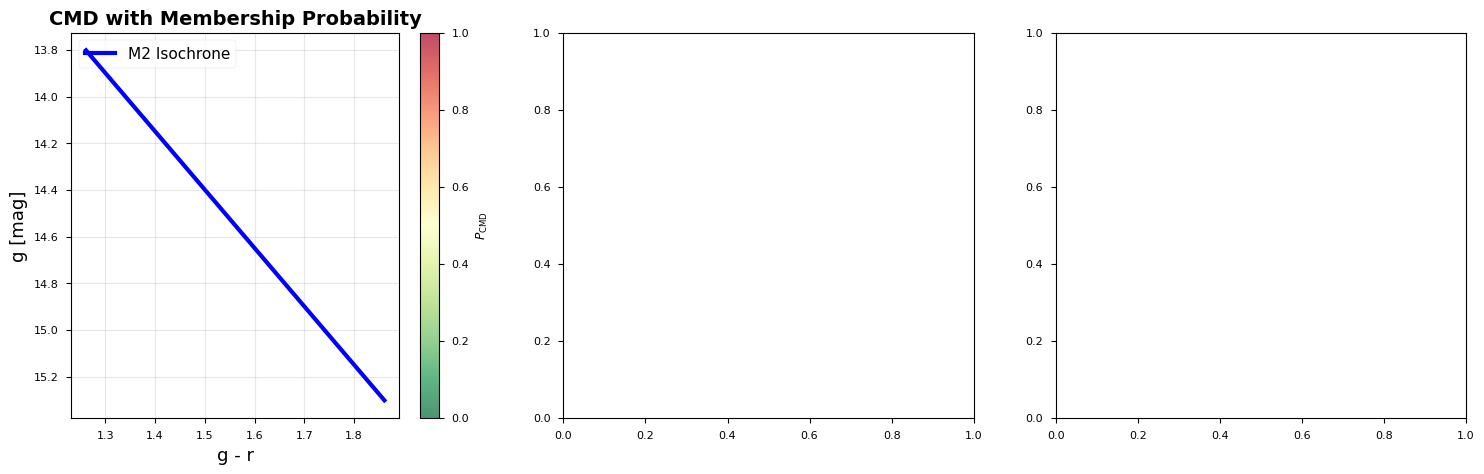

In [6]:
# Compute CMD membership probabilities
P_cmd, d_cmd = cmd_membership_probability(
    stars_color, stars_g,
    color_iso_M2, g_iso_M2,
    sigma_color, sigma_g,
    n_sigma_cut=3.0
)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: CMD colored by membership probability
ax = axes[0]
scatter = ax.scatter(stars_color, stars_g, c=P_cmd, s=15, cmap='RdYlGn_r', 
                     vmin=0, vmax=1, alpha=0.7, edgecolors='none')
ax.plot(color_iso_M2, g_iso_M2, 'b-', lw=3, label='M2 Isochrone', zorder=10)
ax.set_xlabel('g - r', fontsize=13)
ax.set_ylabel('g [mag]', fontsize=13)
ax.set_title('CMD with Membership Probability', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='$P_{\mathrm{CMD}}$')

# Panel 2: Distance distribution
ax = axes[1]
ax.hist(d_cmd[true_labels==1], bins=30, alpha=0.7, label='True members', 
        color='green', edgecolor='black', linewidth=1.2)
ax.hist(d_cmd[true_labels==0], bins=30, alpha=0.7, label='Field stars',
        color='red', edgecolor='black', linewidth=1.2)
ax.axvline(1.0, color='blue', linestyle='--', lw=2, label='1σ')
ax.axvline(2.0, color='orange', linestyle='--', lw=2, label='2σ')
ax.axvline(3.0, color='red', linestyle='--', lw=2, label='3σ cutoff')
ax.set_xlabel('Distance to Isochrone [σ]', fontsize=13)
ax.set_ylabel('Number of Stars', fontsize=13)
ax.set_title('CMD Distance Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Panel 3: Probability distribution
ax = axes[2]
ax.hist(P_cmd[true_labels==1], bins=np.linspace(0, 1, 30), alpha=0.7,
        label=f'True members (N={N_members})', color='green', 
        edgecolor='black', linewidth=1.2)
ax.hist(P_cmd[true_labels==0], bins=np.linspace(0, 1, 30), alpha=0.7,
        label=f'Field stars (N={N_field})', color='red',
        edgecolor='black', linewidth=1.2)
ax.axvline(0.5, color='black', linestyle='--', lw=2, label='P=0.5 threshold')
ax.set_xlabel('$P_{\mathrm{CMD}}$', fontsize=13)
ax.set_ylabel('Number of Stars', fontsize=13)
ax.set_title('Membership Probability Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative assessment
threshold = 0.5
predicted_members = P_cmd > threshold
true_members = true_labels == 1

TP = np.sum(predicted_members & true_members)
FP = np.sum(predicted_members & ~true_members)
TN = np.sum(~predicted_members & ~true_members)
FN = np.sum(~predicted_members & true_members)

completeness = TP / (TP + FN)
purity = TP / (TP + FP)
accuracy = (TP + TN) / N_total

print("\n" + "="*60)
print("CMD-ONLY MEMBERSHIP PERFORMANCE")
print("="*60)
print(f"Threshold: P_CMD > {threshold}")
print(f"\nConfusion Matrix:")
print(f"  True Positives:  {TP:4d}")
print(f"  False Positives: {FP:4d}")
print(f"  True Negatives:  {TN:4d}")
print(f"  False Negatives: {FN:4d}")
print(f"\nMetrics:")
print(f"  Completeness (recall): {completeness:.1%} - fraction of true members recovered")
print(f"  Purity (precision):    {purity:.1%} - fraction of selected stars that are members")
print(f"  Accuracy:              {accuracy:.1%} - overall correct classification rate")
print("="*60)
print("\n⚠️  CMD alone is not sufficient! Contamination is still significant.")
print("    → Need to combine with proper motion and spatial information")